In [143]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv("flicker8k/captions.txt")
import random
from torchvision import transforms
from PIL import Image
import numpy as np
import torch
from data_loader import get_loader
from model_imagecaptioning import VisionWithTransformer


In [144]:
def caption_generator(image,model, device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    model.eval()
    test_img1 = transform(Image.open(f"flicker8k/Images/{image}").convert("RGB")).unsqueeze(0)
    
    caption = " ".join(model.Caption_Generation(test_img1.to(device), dataset.vocab))

    return caption
    

In [145]:
transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            
        ]
    )

def plot_results(images, original_cpation,generated_captions):
    # fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        image =transform(Image.open(f"flicker8k/Images/{images[i]}"))
        image = np.transpose(image, (1, 2, 0))
        
        plt.title("Original: "+original_cpation[i] +"\n Generated: " + generated_captions[i])
        plt.imshow(image)
        plt.axis("off")
        # plt.savefig(f"results/{i}", dpi=300, bbox_inches="tight") 
        plt.show()

In [146]:


idx = random.sample(range(0,len(data)), k=5)
imgs=data.iloc[idx]["image"].to_list()
original_captions = data.iloc[idx]["caption"].to_list()

idx

[32033, 26455, 25946, 17706, 18312]

In [147]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# DataLoader
loader, dataset = get_loader(
    "flicker8k/Images", "flicker8k/captions.txt", transform=transform
)

vocab_size = len(dataset.vocab)
print("Total number of words in vocab:", vocab_size)
# print("vOCAB:", dataset.vocab)
model = VisionWithTransformer(vocab_size=vocab_size).to(device)

model_filename = "saved_model_31st.pt"
print(f'Preloading model {model_filename}')
state = torch.load(model_filename, weights_only= True)
model.load_state_dict(state['model_state_dict'])

cuda
Total number of words in vocab: 2994
Preloading model saved_model_31st.pt


<All keys matched successfully>

In [148]:
generated_captions = []
references = {}
generated = {}

for idx,image in enumerate(imgs) :

    caption = caption_generator(image,model,device,dataset)
    print(caption.replace("<SOS>","").replace("<EOS>", ""))
    generated_captions.append(caption.replace("<SOS>","").replace("<EOS>", ""))
    references[idx] = [original_captions[idx]]
    generated[idx] = [caption.replace("<SOS>","").replace("<EOS>", "")]

 two child are laughing and playing in a tire swing . 
 a group of girls and guys are posing for a picture . 
 a person on a dirt bike doing a trick over a hill . 
 a golden retriever is biting a branch in a yard . 
 a black and white dog is running on the grass . 


In [149]:
generated_captions

[' two child are laughing and playing in a tire swing . ',
 ' a group of girls and guys are posing for a picture . ',
 ' a person on a dirt bike doing a trick over a hill . ',
 ' a golden retriever is biting a branch in a yard . ',
 ' a black and white dog is running on the grass . ']

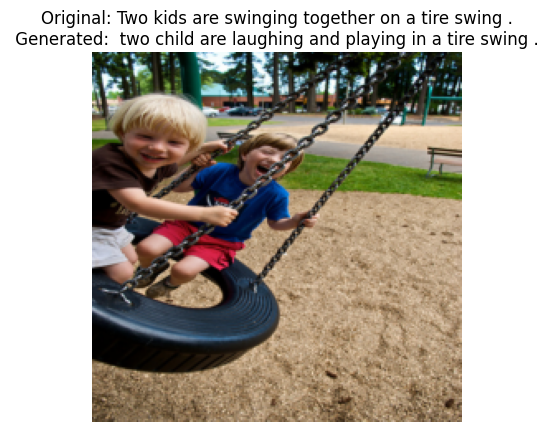

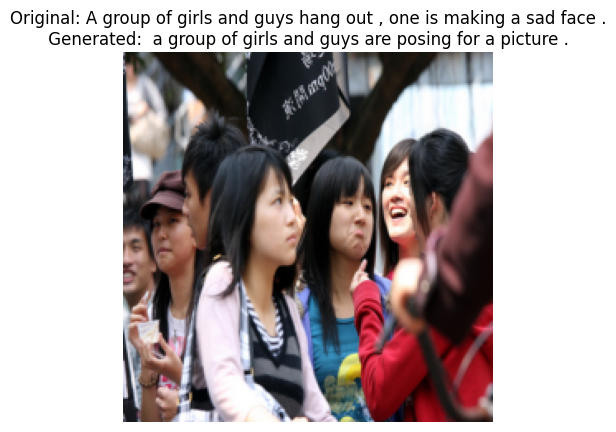

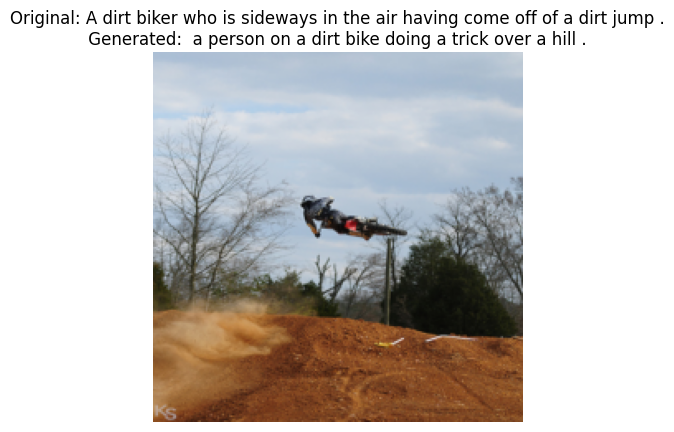

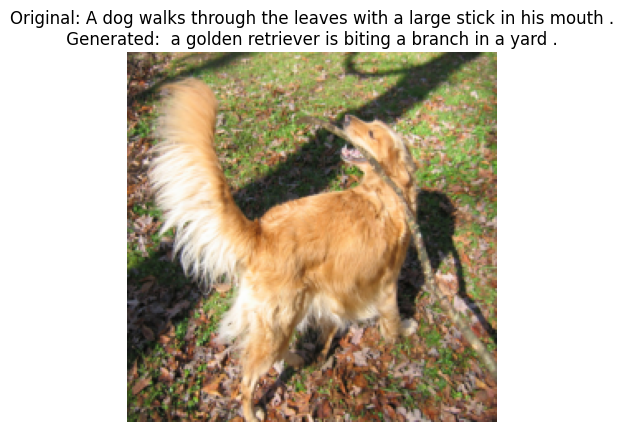

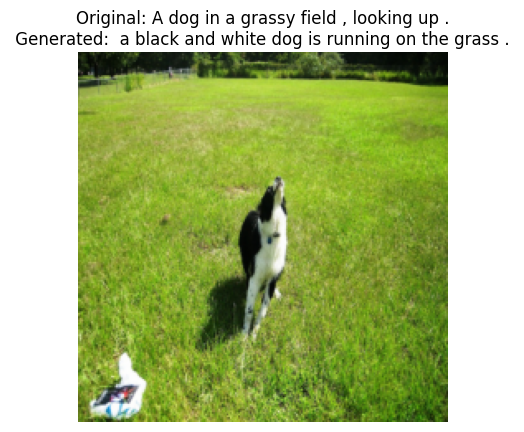

In [150]:
plot_results(imgs,original_captions,generated_captions)

In [151]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider


# Initialize scorers (excluding METEOR and SPICE)
scorers = {
    "BLEU": Bleu(4),
    "ROUGE": Rouge(),
    "CIDEr": Cider()
}

# Compute scores
for metric, scorer in scorers.items():
    score, _ = scorer.compute_score(references, generated)
    print(f"{metric} Score:", score if isinstance(score, float) else score[0])


{'testlen': 58, 'reflen': 67, 'guess': [58, 53, 48, 43], 'correct': [21, 8, 5, 3]}
ratio: 0.8656716417781243
BLEU Score: 0.3100278996596264
ROUGE Score: 0.2981277995508377
CIDEr Score: 1.1443196163125537
